In [97]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [69]:
df = pd.read_csv("C:/Users/Dell/Desktop/SentAnalDs.csv", encoding='ISO-8859-1')
df.head()

,id,sentiment,date,text,Unnamed: 4,Unnamed: 5
0,623495523,1,Mon Dec 01 20:46:01 +0000 2014,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...,NaN,NaN
1,623495527,1,Mon Dec 01 21:09:50 +0000 2014,@apple Contact sync between Yosemite and iOS8 ...,NaN,NaN
2,623495529,1,Mon Dec 01 21:35:14 +0000 2014,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...,NaN,NaN
3,623495536,1,Mon Dec 01 23:55:55 +0000 2014,"@Apple, For the love of GAWD, CENTER the '1'on...",NaN,NaN
4,623495537,1,Tue Dec 02 00:06:05 +0000 2014,i get the storage almost full notification lit...,NaN,NaN


In [70]:
df = df.drop(['id', 'Unnamed: 4', 'Unnamed: 5', 'date'], axis=1)

In [71]:
df.head()

,sentiment,text
0,1,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
1,1,@apple Contact sync between Yosemite and iOS8 ...
2,1,WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...
3,1,"@Apple, For the love of GAWD, CENTER the '1'on..."
4,1,i get the storage almost full notification lit...


In [72]:
df['sentiment'].unique()

array(['1', '3', '5', 'not_relevant'], dtype=object)

---

In [73]:
nltk.download('stopwords')
nltk.download("punkt")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
# preprocessing
def remove_url(text):
    text = text.replace(r'http\S+', '', regex=True)
    return text

df['text'] = remove_url(df['text'])
df['text'] = df['text'].str.lower()
df['text']

0       wtf my battery was 31% one second ago and now ...
1       @apple contact sync between yosemite and ios8 ...
2       warning if you buy an iphone 5s unlocked from ...
3       @apple, for the love of gawd, center the '1'on...
4       i get the storage almost full notification lit...
                              ...                        
3881    #aapl:accel partners leads $50m series c fundi...
3882    counting down the minutes! interest in full ti...
3883          @justinpulitzer any comment on #aapl today?
3884    have been brave and taken out an #aapl cfd as ...
3885    tim cook met with jesse jackson for 'positive ...
Name: text, Length: 3886, dtype: object

In [75]:
def remove_punctuation(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

df['text'] = df['text'].apply(lambda x: remove_punctuation(x))
df['text']

0       wtf my battery was 31 one second ago and now i...
1       apple contact sync between yosemite and ios8 i...
2       warning if you buy an iphone 5s unlocked from ...
3       apple for the love of gawd center the 1on the ...
4       i get the storage almost full notification lit...
                              ...                        
3881    aaplaccel partners leads 50m series c funding ...
3882    counting down the minutes interest in full tim...
3883             justinpulitzer any comment on aapl today
3884    have been brave and taken out an aapl cfd as t...
3885    tim cook met with jesse jackson for positive a...
Name: text, Length: 3886, dtype: object

In [76]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    text = " ".join(words)
    return text

df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text']

0              wtf battery 31 one second ago 29 wtf apple
1       apple contact sync yosemite ios8 seriously scr...
2       warning buy iphone 5s unlocked apple iphone ca...
3       apple love gawd center 1on damn calendar app f...
4       get storage almost full notification literally...
                              ...                        
3881    aaplaccel partners leads 50m series c funding ...
3882    counting minutes interest full time trading st...
3883                    justinpulitzer comment aapl today
3884         brave taken aapl cfd drop 110 seems overdone
3885    tim cook met jesse jackson positive productive...
Name: text, Length: 3886, dtype: object

In [77]:
df['text'] = df['text'].str.split()
df['text']

0       [wtf, battery, 31, one, second, ago, 29, wtf, ...
1       [apple, contact, sync, yosemite, ios8, serious...
2       [warning, buy, iphone, 5s, unlocked, apple, ip...
3       [apple, love, gawd, center, 1on, damn, calenda...
4       [get, storage, almost, full, notification, lit...
                              ...                        
3881    [aaplaccel, partners, leads, 50m, series, c, f...
3882    [counting, minutes, interest, full, time, trad...
3883               [justinpulitzer, comment, aapl, today]
3884    [brave, taken, aapl, cfd, drop, 110, seems, ov...
3885    [tim, cook, met, jesse, jackson, positive, pro...
Name: text, Length: 3886, dtype: object

In [78]:
df.head()

,sentiment,text
0,1,"[wtf, battery, 31, one, second, ago, 29, wtf, ..."
1,1,"[apple, contact, sync, yosemite, ios8, serious..."
2,1,"[warning, buy, iphone, 5s, unlocked, apple, ip..."
3,1,"[apple, love, gawd, center, 1on, damn, calenda..."
4,1,"[get, storage, almost, full, notification, lit..."


In [79]:
rows = [word for tweet in df['text'] for word in tweet]
word_freq = Counter(rows)
for word, freq in word_freq.items():
    print(f'Word: {word}, Frequency: {freq}')


Word: wtf, Frequency: 29
Word: battery, Frequency: 40
Word: 31, Frequency: 2
Word: one, Frequency: 387
Word: second, Frequency: 10
Word: ago, Frequency: 9
Word: 29, Frequency: 1
Word: apple, Frequency: 3768
Word: contact, Frequency: 5
Word: sync, Frequency: 7
Word: yosemite, Frequency: 32
Word: ios8, Frequency: 18
Word: seriously, Frequency: 9
Word: screwed, Frequency: 2
Word: used, Frequency: 13
Word: much, Frequency: 41
Word: stable, Frequency: 1
Word: past, Frequency: 8
Word: icloud, Frequency: 13
Word: isync, Frequency: 1
Word: warning, Frequency: 1
Word: buy, Frequency: 56
Word: iphone, Frequency: 358
Word: 5s, Frequency: 11
Word: unlocked, Frequency: 1
Word: cannot, Frequency: 8
Word: use, Frequency: 50
Word: verizon, Frequency: 9
Word: network, Frequency: 7
Word: love, Frequency: 51
Word: gawd, Frequency: 2
Word: center, Frequency: 17
Word: 1on, Frequency: 1
Word: damn, Frequency: 16
Word: calendar, Frequency: 4
Word: app, Frequency: 92
Word: fixed, Frequency: 4
Word: back, Freq

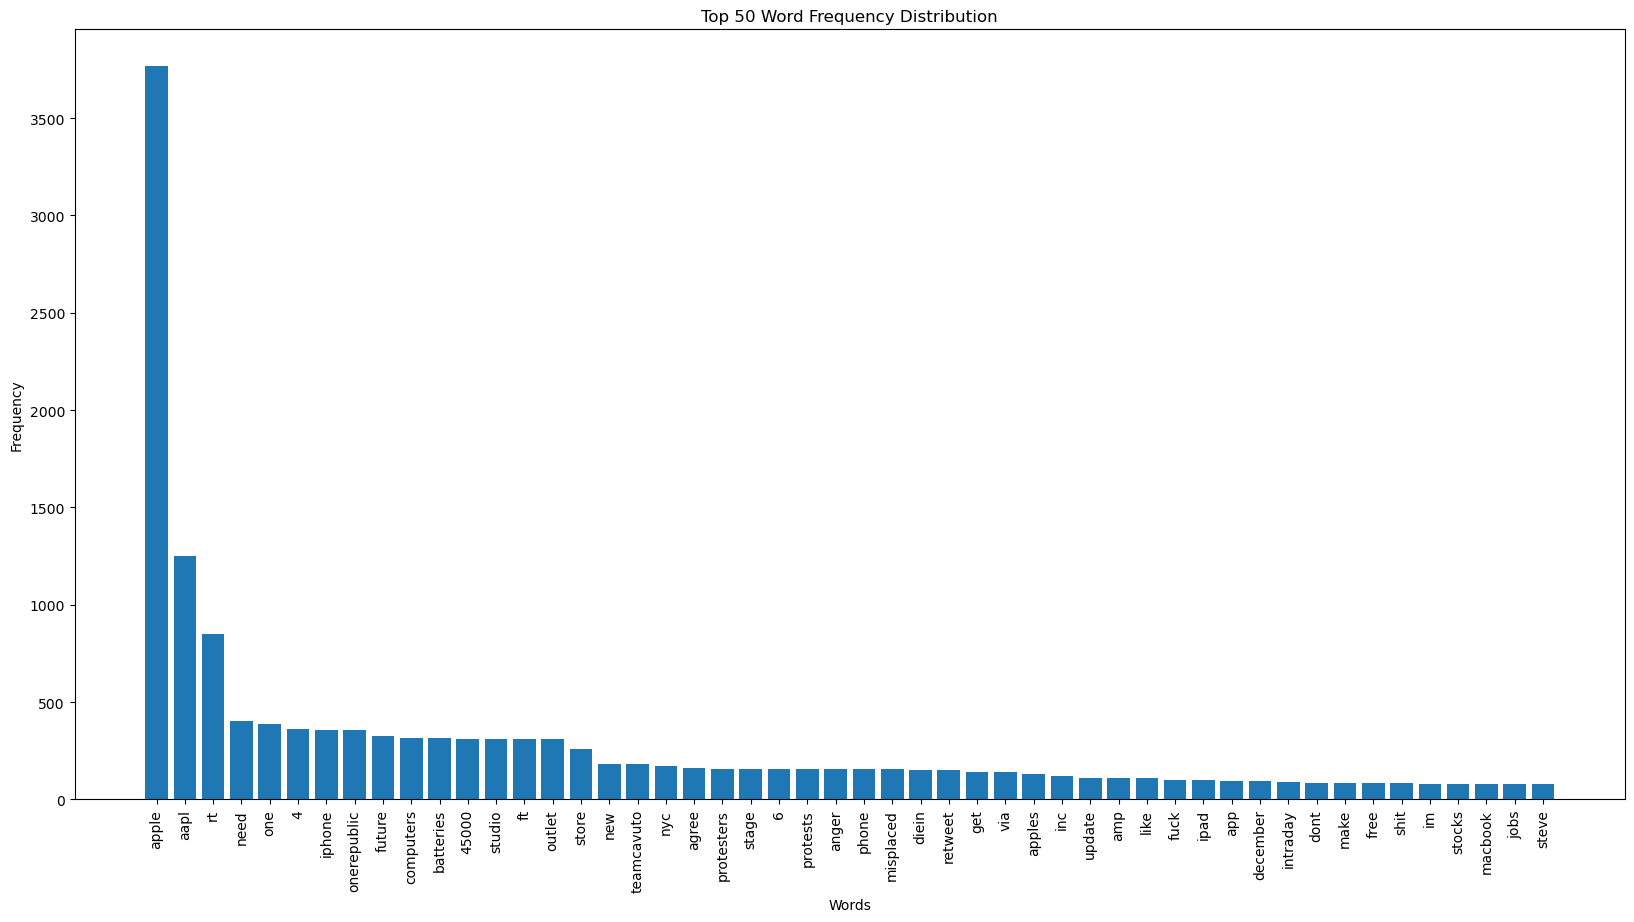

In [80]:
top_words = word_freq.most_common(50)
words, frequencies = zip(*top_words)

plt.figure(figsize=(20,10))
plt.bar(words, frequencies)
plt.title('Top 50 Word Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [81]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# learned through AI we could specialize the stemming/lemmatization based on the
# parts of speech. i tried to do this w nouns and verbs only
def verb_or_noun(nltk_tag):
    if nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    else:          
        return None

def lemmatize_sentence(sentence):

    nounverb_tag = nltk.pos_tag(nltk.word_tokenize(sentence))  
    tagged = map(lambda x: (x[0], verb_or_noun(x[0])), nounverb_tag)
    lemmatized_sentence = []
    for word, tag in tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

df['text'] = df['text'].apply(lambda x: [stemmer.stem(word) for word in x])
df['text'] = df['text'].apply(lambda x: " ".join(x))
df['text'] = df['text'].apply(lambda x: lemmatize_sentence(x))

df['text']


0       [wtf, batteri, 31, one, second, ago, 29, wtf, ...
1       [appl, contact, sync, yosemit, ios8, serious, ...
2       [warn, buy, iphon, 5s, unlock, appl, iphon, ca...
3       [appl, love, gawd, center, 1on, damn, calendar...
4       [get, storag, almost, full, notif, liter, ever...
                              ...                        
3881    [aaplaccel, partner, lead, 50m, seri, c, fund,...
3882    [count, minut, interest, full, time, trade, st...
3883                 [justinpulitz, comment, aapl, today]
3884    [brave, taken, aapl, cfd, drop, 110, seem, ove...
3885    [tim, cook, met, jess, jackson, posit, product...
Name: text, Length: 3886, dtype: object

---

In [85]:
df['text'] = [' '.join(doc) for doc in df['text']]

In [86]:
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(df['text'])


In [87]:
print(X_counts)

  (0, 5591)	2
  (0, 789)	1
  (0, 161)	1
  (0, 3705)	1
  (0, 4439)	1
  (0, 433)	1
  (0, 152)	1
  (0, 579)	1
  (1, 579)	1
  (1, 1335)	1
  (1, 4899)	1
  (1, 5652)	1
  (1, 2770)	1
  (1, 4477)	1
  (1, 4426)	1
  (1, 5316)	1
  (1, 3502)	1
  (1, 4739)	1
  (1, 3825)	1
  (1, 2632)	1
  (1, 2826)	1
  (2, 579)	1
  (2, 5316)	1
  (2, 5414)	1
  (2, 1030)	1
  :	:
  (3882, 4708)	1
  (3882, 2141)	1
  (3882, 2347)	1
  (3882, 4088)	1
  (3883, 5099)	1
  (3883, 289)	1
  (3883, 1274)	1
  (3883, 2939)	1
  (3884, 289)	1
  (3884, 1733)	1
  (3884, 4452)	1
  (3884, 4918)	1
  (3884, 1131)	1
  (3884, 29)	1
  (3884, 957)	1
  (3884, 3767)	1
  (3885, 289)	1
  (3885, 4033)	1
  (3885, 3964)	1
  (3885, 5076)	1
  (3885, 1344)	1
  (3885, 1640)	1
  (3885, 2878)	1
  (3885, 2853)	1
  (3885, 3357)	1


In [89]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

In [90]:
print(X_tfidf)

  (0, 579)	0.05557903260654586
  (0, 152)	0.4311022268586984
  (0, 433)	0.35016284548159554
  (0, 4439)	0.3332415001645197
  (0, 3705)	0.1661791892672326
  (0, 161)	0.4107111979369047
  (0, 789)	0.17079124870101425
  (0, 5591)	0.593236094363105
  (1, 2826)	0.3564993785257415
  (1, 2632)	0.2819843499259565
  (1, 3825)	0.29394836531113844
  (1, 4739)	0.3564993785257415
  (1, 3502)	0.23191397525319868
  (1, 5316)	0.20308762725820972
  (1, 4426)	0.31839301923816554
  (1, 4477)	0.2895666712431766
  (1, 2770)	0.2628734897607175
  (1, 5652)	0.24119398654578564
  (1, 4899)	0.29394836531113844
  (1, 1335)	0.2895666712431766
  (1, 579)	0.045961002631957834
  (2, 3573)	0.3432252174321419
  (2, 5351)	0.3325671305942875
  (2, 3639)	0.33759950333617783
  (2, 1058)	0.33759950333617783
  :	:
  (3882, 5138)	0.19714101534844453
  (3882, 5140)	0.28434359256496783
  (3882, 3402)	0.2697371509828594
  (3882, 2207)	0.2722794793720958
  (3883, 2939)	0.7035988801047088
  (3883, 1274)	0.49443923509526444
  (388

In [91]:
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
X_ngram = ngram_vectorizer.fit_transform(df['text'])

In [92]:
print(X_ngram)

  (0, 42610)	2
  (0, 7506)	1
  (0, 742)	1
  (0, 28230)	1
  (0, 33825)	1
  (0, 2328)	1
  (0, 709)	1
  (0, 3593)	1
  (0, 42618)	1
  (0, 7507)	1
  (0, 745)	1
  (0, 28324)	1
  (0, 33826)	1
  (0, 2329)	1
  (0, 710)	1
  (0, 42611)	1
  (0, 42619)	1
  (0, 7508)	1
  (0, 746)	1
  (0, 28325)	1
  (0, 33827)	1
  (0, 2330)	1
  (0, 711)	1
  (1, 3593)	1
  (1, 11157)	1
  :	:
  (3884, 141)	1
  (3885, 1285)	1
  (3885, 30749)	1
  (3885, 30259)	1
  (3885, 38541)	1
  (3885, 11240)	1
  (3885, 38542)	1
  (3885, 13181)	1
  (3885, 22325)	1
  (3885, 22221)	1
  (3885, 22326)	1
  (3885, 25796)	1
  (3885, 11261)	1
  (3885, 25797)	1
  (3885, 22222)	1
  (3885, 30272)	1
  (3885, 30771)	1
  (3885, 13182)	1
  (3885, 38551)	1
  (3885, 11262)	1
  (3885, 25798)	1
  (3885, 22327)	1
  (3885, 22223)	1
  (3885, 30273)	1
  (3885, 30772)	1


In [94]:
labelencoder = LabelEncoder()
df['sentiment'] = labelencoder.fit_transform(df['sentiment'])
df['sentiment'].unique()

array([0, 1, 2, 3])

In [96]:
def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [98]:
def calculate_metrics(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision_macro = metrics.precision_score(y_test, y_pred, average='macro')
    precision_micro = metrics.precision_score(y_test, y_pred, average='micro')
    recall_macro = metrics.recall_score(y_test, y_pred, average='macro')
    recall_micro = metrics.recall_score(y_test, y_pred, average='micro')
    f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
    f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
    return accuracy, precision_macro, precision_micro, recall_macro, recall_micro, f1_macro, f1_micro

In [129]:
def nlp_models(X_train, X_test, y_train, y_test):
    vectorizer = CountVectorizer()
    X_train_counts = X_train
    X_test_counts = X_test

    classifiers = {
        'Naive Bayes': MultinomialNB(), # idk how to get the i two dots
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'SVM': svm.SVC(),
        'Perceptron': Perceptron()
    }
    p_mac = [0,0,0,0,0]
    r_mac = [0,0,0,0,0]
    f_mac = [0,0,0,0,0]
    p_mic = [0,0,0,0,0]
    r_mic = [0,0,0,0,0]
    f_mic = [0,0,0,0,0]
    i = 0
    for name, classifier in classifiers.items():
        classifier.fit(X_train_counts, y_train)
        y_pred = classifier.predict(X_test_counts)
        accuracy, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro = calculate_metrics(y_test, y_pred)
        p_mac[i] = precision_macro
        p_mic[i] = precision_micro
        r_mac[i] = recall_macro
        r_mic[i] = recall_micro
        f_mac[i] = f1_macro
        f_mic[i] = f1_micro
        i += 1
        print(f'{name}:')
        print(f'Accuracy: {round(accuracy,3)*100}')
        print(f'Precision (macro): {round(precision_macro,3)*100}')
        print(f'Recall (macro): {round(recall_macro,3)*100}')
        print(f'F1-score (macro): {round(f1_macro,3)*100}')
        print(f'Precision (micro): {round(precision_micro,3)*100}')
        print(f'Recall (micro): {round(recall_micro,3)*100}')
        print(f'F1-score (micro): {round(f1_micro,3)*100}')
        print(" ")

    precision_macro = p_mac
    recall_macro = r_mac
    f1_macro = f_mac
    precision_micro = p_mic
    recall_micro = r_mic
    f1_micro = f_mic
    macro = [precision_macro, recall_macro, f1_macro]
    micro = [precision_micro, recall_micro, f1_micro]
    return macro, micro

In [130]:
# 1. BOW
X_train, X_test, y_train, y_test = split_dataset(X_counts, df['sentiment'])
print("TRAINING FOR BAG OF WORDS")
print(" ")
bow_mac, bow_mic = nlp_models(X_train, X_test, y_train, y_test)

TRAINING FOR BAG OF WORDS
 
Naive Bayes:
Accuracy: 68.8
Precision (macro): 54.50000000000001
Recall (macro): 68.8
F1-score (macro): 49.4
Precision (micro): 68.8
Recall (micro): 50.8
F1-score (micro): 68.8
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
Accuracy: 74.7
Precision (macro): 53.0
Recall (macro): 74.7
F1-score (macro): 45.5
Precision (micro): 74.7
Recall (micro): 47.199999999999996
F1-score (micro): 74.7
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest:
Accuracy: 73.4
Precision (macro): 51.800000000000004
Recall (macro): 73.4
F1-score (macro): 44.800000000000004
Precision (micro): 73.4
Recall (micro): 46.5
F1-score (micro): 73.4
 
SVM:
Accuracy: 73.9
Precision (macro): 59.0
Recall (macro): 73.9
F1-score (macro): 43.3
Precision (micro): 73.9
Recall (micro): 45.4
F1-score (micro): 73.9
 
Perceptron:
Accuracy: 73.0
Precision (macro): 57.49999999999999
Recall (macro): 73.0
F1-score (macro): 51.0
Precision (micro): 73.0
Recall (micro): 53.300000000000004
F1-score (micro): 73.0
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
# 2. TF-IDF
X_train, X_test, y_train, y_test = split_dataset(X_tfidf, df['sentiment'])
print("TRAINING FOR TF-IDF")
print(" ")
tfidf_mac, tfidf_mic = nlp_models(X_train, X_test, y_train, y_test)

TRAINING FOR TF-IDF
 
Naive Bayes:
Accuracy: 73.5
Precision (macro): 58.599999999999994
Recall (macro): 73.5
F1-score (macro): 41.5
Precision (micro): 73.5
Recall (micro): 41.699999999999996
F1-score (micro): 73.5
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression:
Accuracy: 74.2
Precision (macro): 59.5
Recall (macro): 74.2
F1-score (macro): 43.5
Precision (micro): 74.2
Recall (micro): 45.300000000000004
F1-score (micro): 74.2
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest:
Accuracy: 73.3
Precision (macro): 53.5
Recall (macro): 73.3
F1-score (macro): 43.5
Precision (micro): 73.3
Recall (micro): 45.300000000000004
F1-score (micro): 73.3
 
SVM:
Accuracy: 73.7
Precision (macro): 59.099999999999994
Recall (macro): 73.7
F1-score (macro): 42.1
Precision (micro): 73.7
Recall (micro): 43.5
F1-score (micro): 73.7
 
Perceptron:
Accuracy: 70.7
Precision (macro): 51.0
Recall (macro): 70.7
F1-score (macro): 48.8
Precision (micro): 70.7
Recall (micro): 49.5
F1-score (micro): 70.7
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
# 3. N-GRAM
X_train, X_test, y_train, y_test = split_dataset(X_ngram, df['sentiment'])
print("TRAINING FOR N-GRAMS")
print(" ")
ngram_mac, ngram_mic = nlp_models(X_train, X_test, y_train, y_test)

TRAINING FOR N-GRAMS
 
Naive Bayes:
Accuracy: 66.5
Precision (macro): 51.6
Recall (macro): 66.5
F1-score (macro): 51.7
Precision (micro): 66.5
Recall (micro): 50.7
F1-score (micro): 66.5
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
Accuracy: 74.4
Precision (macro): 54.800000000000004
Recall (macro): 74.4
F1-score (macro): 45.2
Precision (micro): 74.4
Recall (micro): 47.199999999999996
F1-score (micro): 74.4
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest:
Accuracy: 72.1
Precision (macro): 52.0
Recall (macro): 72.1
F1-score (macro): 42.8
Precision (micro): 72.1
Recall (micro): 44.6
F1-score (micro): 72.1
 
SVM:
Accuracy: 72.0
Precision (macro): 60.099999999999994
Recall (macro): 72.0
F1-score (macro): 40.2
Precision (micro): 72.0
Recall (micro): 41.199999999999996
F1-score (micro): 72.0
 
Perceptron:
Accuracy: 67.7
Precision (macro): 51.5
Recall (macro): 67.7
F1-score (macro): 46.800000000000004
Precision (micro): 67.7
Recall (micro): 47.199999999999996
F1-score (micro): 67.7
 


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [139]:
bow_mac

[[0.545074416717113,
  0.5302019624927993,
  0.518200505842181,
  0.590313325660934,
  0.5749938496548118],
 [0.6876606683804627,
  0.7467866323907455,
  0.7339331619537275,
  0.7390745501285347,
  0.7300771208226221],
 [0.4935927278457044,
  0.4550876192471379,
  0.4480332951199358,
  0.4333264714097834,
  0.5096266688332365]]

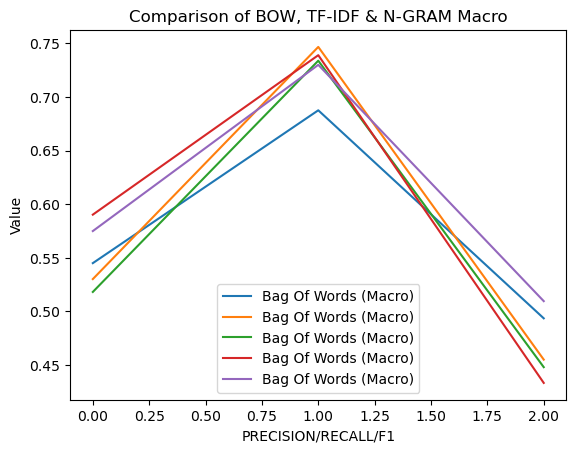

In [144]:
# MACRO COMPARISON

plt.plot(bow_mac, label='Bag Of Words (Macro)')

plt.xlabel('PRECISION/RECALL/F1')
plt.ylabel('Value')
plt.title('Comparison of BOW, TF-IDF & N-GRAM Macro')
plt.legend()

plt.show()

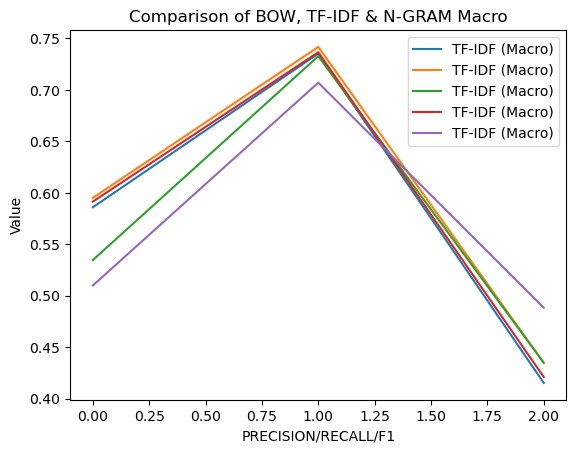

In [145]:
# MACRO COMPARISON

plt.plot(tfidf_mac, label='TF-IDF (Macro)')

plt.xlabel('PRECISION/RECALL/F1')
plt.ylabel('Value')
plt.title('Comparison of BOW, TF-IDF & N-GRAM Macro')
plt.legend()

plt.show()

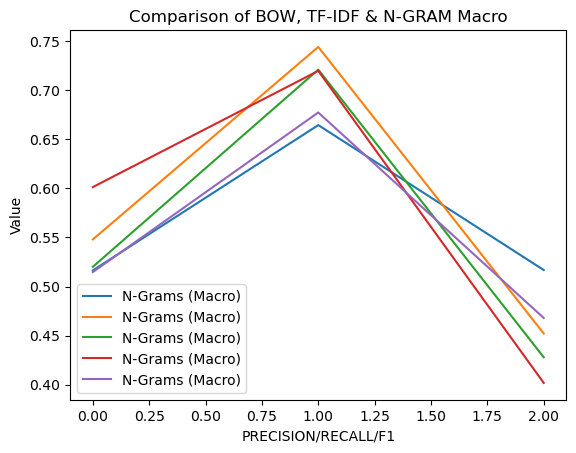

In [146]:
# MACRO COMPARISON

plt.plot(ngram_mac, label='N-Grams (Macro)')

plt.xlabel('PRECISION/RECALL/F1')
plt.ylabel('Value')
plt.title('Comparison of BOW, TF-IDF & N-GRAM Macro')
plt.legend()

plt.show()

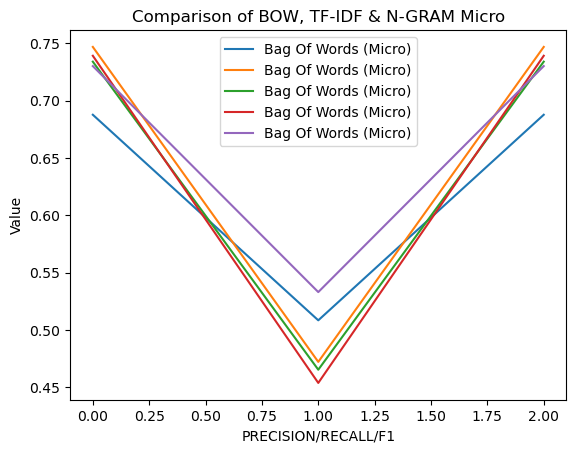

In [149]:
# MICRO COMPARISON

plt.plot(bow_mic, label='Bag Of Words (Micro)')

plt.xlabel('PRECISION/RECALL/F1')
plt.ylabel('Value')
plt.title('Comparison of BOW, TF-IDF & N-GRAM Micro')
plt.legend()

plt.show()

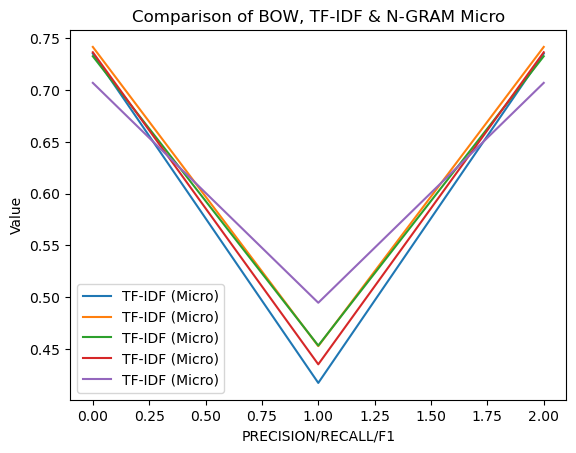

In [150]:
# MICRO COMPARISON

plt.plot(tfidf_mic, label='TF-IDF (Micro)')

plt.xlabel('PRECISION/RECALL/F1')
plt.ylabel('Value')
plt.title('Comparison of BOW, TF-IDF & N-GRAM Micro')
plt.legend()

plt.show()

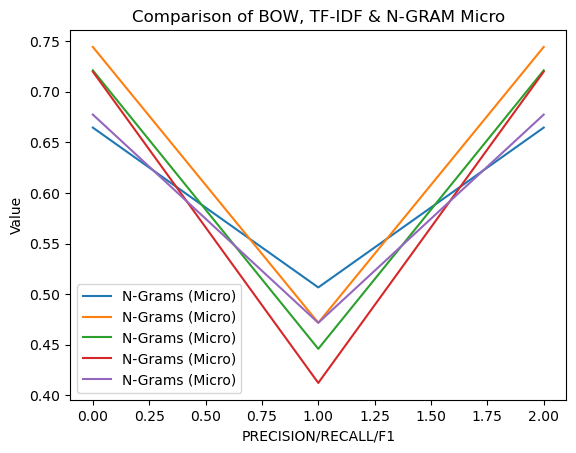

In [151]:
# MICRO COMPARISON

plt.plot(ngram_mic, label='N-Grams (Micro)')

plt.xlabel('PRECISION/RECALL/F1')
plt.ylabel('Value')
plt.title('Comparison of BOW, TF-IDF & N-GRAM Micro')
plt.legend()

plt.show()